In [13]:
import sys
import torch
import os
import argparse
import numpy as np
# from utils.train_options import TrainOptions
from kd import KD_model
import pandas as pd
from torch.autograd import Variable
from loss import cross_ent_dice_loss, dice_coeff_multiclass
import logging
import warnings
from tqdm import tqdm
import wandb
from loss import *


from dataset import Mean_Prior_MSD, get_train_val_loader, Spine


In [2]:
root_dir = '../../data/SpineCT_processed/train/'
imgdir = 'imagesTr'
labeldir = 'labelsTr'
labeldir_left = 'labels_left'
labeldir_right = 'labels_right'

In [6]:
validation_split = 0.2
shuffle_dataset = True
random_seed= 42
train_ratio = 1
# dataset = Mean_Prior_MSD(root = root_dir, imgdir = imgdir, labeldir = labeldir, labeldir_left = labeldir_left, \
# 	labeldir_right = labeldir_right, prior_list = prior_list, \
# 		device = torch.device("cuda:1"), train_ratio = train_ratio)
dataset = Spine(root = root_dir, imgdir = imgdir, labeldir = labeldir, device = torch.device("cuda:1"))

train_loader, validation_loader = get_train_val_loader(dataset_obj = dataset, validation_split = validation_split, \
		batch_size = 4, train_ratio = 1, n_cpus = 4)

In [7]:
from teacher import UNet2D

In [12]:
model = UNet2D(num_classes=3, num_channels=1)
model.to('cuda:0')
model.load_state_dict(torch.load('teacher_model/spine_teacher_0.pt'))

<All keys matched successfully>








train: Avg loss0.0, avg_dice0.0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 0/1688 [00:00<?,

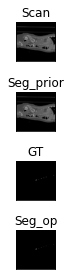

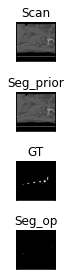

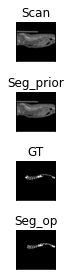

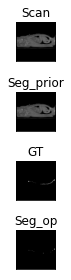

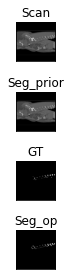

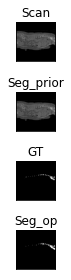

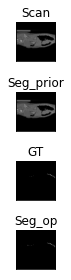

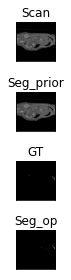

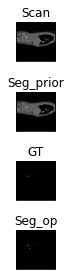

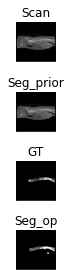

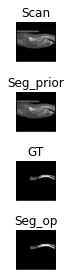

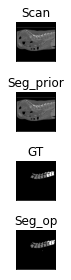

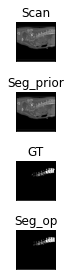

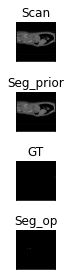

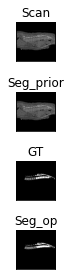

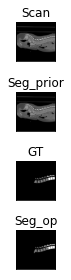

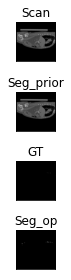

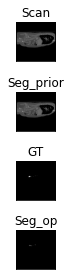

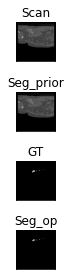

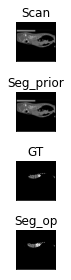

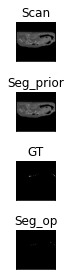

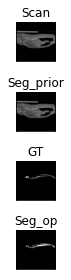

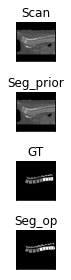

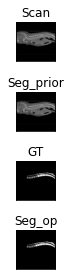

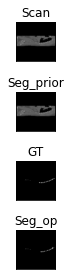

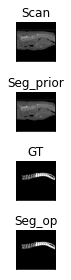

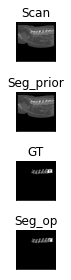

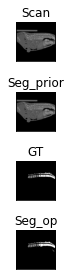

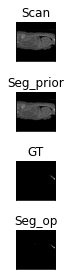

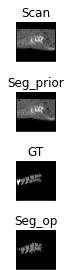

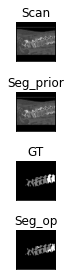

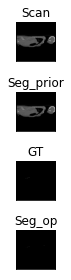

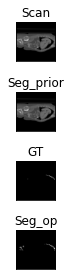

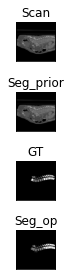

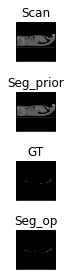

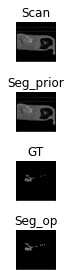

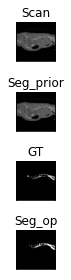

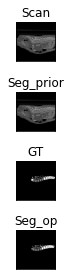

KeyboardInterrupt: 

In [24]:
for epoch in range(1, 2):
    # print('Epoch: ', epoch)
    # model.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        # optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch['img']).to('cuda:0')
#         print(input_img[0][0].shape)
        segs = Variable(batch['seg']).type(torch.LongTensor).to('cuda:0')
#         print(segs.shape)
        outputs = model(input_img)
        # print(outputs.shape)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        # optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, 3)
        dscoeffs.append(dscoeff)
        
        
        if (count%10==1):
            fig = plt.figure()
            plt.subplot(4,1,1).imshow(input_img[0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(4,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(4,1,2).imshow(input_img[0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(4,1,2).set_title('Seg_prior')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(4,1,3).imshow(segs[0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(4,1,3).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(4,1,4).imshow(outs[0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(4,1,4).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()